# OpenCV - Exercise 2

Feature extraction using SIFT (Scale-Invariant Feature Transform) and matching of two images

---

In [1]:
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import time

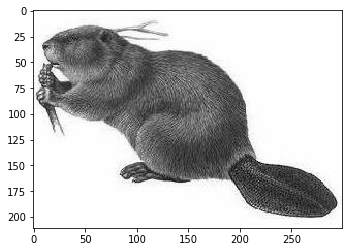

In [2]:
# Load an image
beaver = cv2.imread('beaver.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(beaver, cmap='gray')

## Feature detection and extraction

### 1. Detection

In [3]:
# SIFT feature detector/descriptor
sift = cv2.xfeatures2d.SIFT_create()

In [4]:
# SIFT feature detection
start_time = time.time()
kp = sift.detect(beaver, None) # 2nd pos argument is a mask indicating a part of image to be searched in
print('Elapsed time: %.3fs' % (time.time() - start_time))

Elapsed time: 0.042s


Keypoints detected: 144


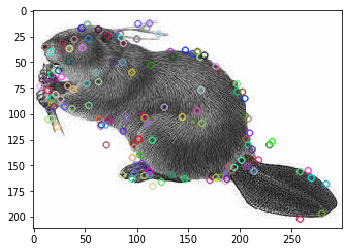

In [5]:
# Display the SIFT features
beaver_sift = cv2.drawKeypoints(beaver, kp, None)
plt.imshow(cv2.cvtColor(beaver_sift, cv2.COLOR_BGR2RGB))
print('Keypoints detected: %d' % len(kp))

### 2. Descriptor extraction

In [6]:
# Extract SIFT feature from the (gray) image and detected keypoints
start_time = time.time()
kp, des = sift.compute(beaver, kp)
print('Elapsed time: %.6fs' % (time.time() - start_time))

# SIFT keypoints and descriptors at the same time
# start_time = time.time()
# kp, des = sift.detectAndCompute(gray, None)
# print('Elapsed time: %.6fs' % (time.time() - start_time))

Elapsed time: 0.011344s


In [7]:
# Inspect the descriptors
print(des.shape)

(144, 128)


In [8]:
print(des[0, :])

[ 57.  42.  30.  40.  49.   1.   0.  20.  37.  35.  16.  29.  43.   2.
   6.  50.  19.  20.  14.   7.  11.  28.  37. 109.  65.   0.   0.   1.
   2.   7.  28. 150.  27.  40.  58.  50.  13.   0.   0.   9. 150.  34.
  24.  23.   5.   0.   8. 134.  50.   8.   3.   0.   0.   0.  51. 150.
   3.   0.   0.   0.   0.   1.  28.  95.  24.   5.  14.  31.  21.  16.
   9.  15. 150.  65.   3.   5.   2.   1.   7.  53. 150.  28.   0.   0.
   0.   0.   2.  45.   4.   0.   0.   0.   0.   1.   2.   7.  21.   2.
   1.   4.   9.  22.  22.  28. 150.  11.   0.   0.   0.   0.  11.  86.
 150.   7.   0.   0.   0.   0.   0.  31.   3.   0.   0.   0.   0.   0.
   0.   2.]


## Feature Matching

### 1. Matching

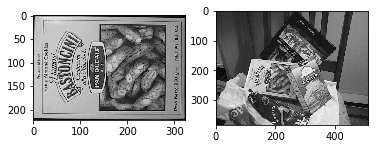

In [9]:
# Open and show images
img1 = cv2.imread('box.png')
img2 = cv2.imread('box_in_scene.png')

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

In [10]:
# Feature extraction
sift = cv2.xfeatures2d.SIFT_create()
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

start_time = time.time()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)
print('Elapsed time: %.6fs' % (time.time() - start_time))

print('Image 1 - %d feature detected' % des1.shape[0])
print('Image 2 - %d feature detected' % des2.shape[0])

Elapsed time: 0.073851s
Image 1 - 603 feature detected
Image 2 - 969 feature detected


In [11]:
# BFMatcher(Brute Force Matcher) with default settings
bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(des1, des2, k=2)

# The matches are returned as a matrix
# Each line corresponds to each point in image 1 
# i.e. number of matches = number of features in image 1
print('%d matches' % len(matches))
# The number of columns is the same as k
# i.e. the k nearest features found in image 2
print('%d nearest features in each line' % len(matches[0]))

603 matches
2 nearest features in each line


In [12]:
# Each matching feature stores: distance, queryIdx, trainIdx and imgIdx
# For the first match:
for i in range(2):
    print(matches[5][i].distance)
    print(matches[5][i].queryIdx) # index in image 1
    print(matches[5][i].trainIdx) # index in image 2
    print(matches[5][i].imgIdx)
    print('---')

324.359375
5
618
0
---
346.14593505859375
5
911
0
---


In [13]:
# Filter matches by applying ratio test
# => if the distance of the two nearest matches is very similar (ratio > 0.75), then it's an ambiguous match
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
print('%d matches' % len(good_matches))

79 matches


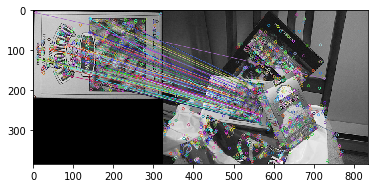

In [14]:
# Display matches
img3 = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))

### 2. Detect object using homography matrix

In [15]:
# Matched points
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

print(src_pts[:3])
print(dst_pts[:3])

[[[  6.894554   6.163354]]

 [[ 12.016466 121.74898 ]]

 [[ 34.135162 126.63357 ]]]
[[[402.35773 170.31085]]

 [[179.8987  240.9843 ]]

 [[119.68749 224.40523]]]


In [16]:
# Find homography matrix with RANSAC algorithm
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()
print(M)

[[ 4.42447766e-01 -1.63205783e-01  1.18844835e+02]
 [ 1.14645499e-03  4.05183296e-01  1.60914002e+02]
 [-2.44051261e-04 -3.51166495e-04  1.00000000e+00]]


In [17]:
# Calculate the object position in the scene using homography
h,w = img1.shape[0:2]
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)
print(dst)

[[[118.84483 160.914  ]]

 [[ 89.59813 272.0754 ]]

 [[267.45782 297.9498 ]]

 [[284.155   175.08609]]]


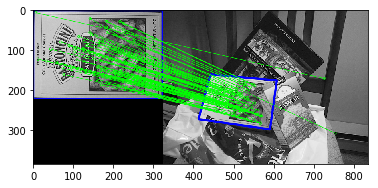

In [18]:
# Display the object
img1 = cv2.polylines(img1,[np.int32(pts)],True,(255,0,0),3, cv2.LINE_AA)
img2 = cv2.polylines(img2,[np.int32(dst)],True,(255,0,0),3, cv2.LINE_AA)

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good_matches,None,**draw_params)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))

### Additional exercises

1. Try the SURF detector and descriptor | [Introduction to SURF (Speeded-Up Robust Features)](https://docs.opencv.org/3.4.1/df/dd2/tutorial_py_surf_intro.html)
 
- Try faster detectors and descriptors (FAST + BRIEF) | [BRIEF (Binary Robust Independent Elementary Features)](https://docs.opencv.org/3.4.1/dc/d7d/tutorial_py_brief.html)


### Acknowledgments

Adapted from OpenCV tutorial by Juyong Kim.

More detailed explanation in the following tutorials:

 - [Introduction to SIFT (Scale-Invariant Feature Transform)](https://docs.opencv.org/3.4.1/da/df5/tutorial_py_sift_intro.html)
 - [Feature Matching + Homography to find Objects](https://docs.opencv.org/3.4.1/dc/da5/tutorial_py_drawing_functions.html)